# Sistema de recomendaciones basado en Filtros Colaborativos
## Universidad del Valle de Guatemala <br> Facultad de Ingeniería
#### Departamento de Ciencias de la Computación <br> Deep Learning y Sistemas Inteligentes - Sección 20 <br><br> Jeyner Arango 201106 <br> Cristian Laynez 201281


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, tensorflow as tf
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

In [2]:
books = pd.read_csv("./data/Books.csv")
ratings = pd.read_csv("./data/Ratings.csv")

C:\Users\Administrador\AppData\Local\Temp\ipykernel_12520\1704119025.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("./data/Books.csv")


In [76]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [3]:
df = pd.read_csv("./data/_AllData.csv")

In [4]:
df.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,"tyler, texas, usa",-1.0
1,276726,0155061224,5,Rites of Passage,Judith Rae,"seattle, washington, usa",-1.0
2,276727,0446520802,0,The Notebook,Nicholas Sparks,"h, new south wales, australia",16.0
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,"rijeka, n/a, croatia",16.0


In [5]:
df.shape

(1149780, 7)

In [6]:
# Sample ISBN preprocessing function
def preprocess_isbn(isbn):
    # Cast to string to ensure it's a string
    isbn = str(isbn)
    
    # Handle ISBN-10 'X' character
    if isbn and isbn[-1] == 'X':
        isbn = isbn[:-1]
    
    # Remove non-numeric characters
    isbn = ''.join(filter(str.isdigit, isbn)) 
    
    # Check if the resulting ISBN is empty or invalid
    if not isbn:
        return None  # or any other suitable placeholder for missing ISBNs
    try:
        isbn = int(isbn)
    except ValueError:
        return None  # Handle cases where conversion to int fails
    
    return isbn

# Apply the preprocessing function to your ISBN data
df['ISBN'] = df['ISBN'].apply(preprocess_isbn)

In [7]:
df.dtypes

User-ID          int64
ISBN           float64
Book-Rating      int64
Book-Title      object
Book-Author     object
Location        object
Age            float64
dtype: object

In [8]:
df.isna().sum()

User-ID             0
ISBN               58
Book-Rating         0
Book-Title     118644
Book-Author    118645
Location            0
Age                 0
dtype: int64

In [9]:
df.shape

(1149780, 7)

In [10]:
df = df[df['ISBN'] != 0]

In [11]:
df.dropna(subset=['ISBN'], inplace = True)

In [12]:
df.isna().sum()

User-ID             0
ISBN                0
Book-Rating         0
Book-Title     118520
Book-Author    118521
Location            0
Age                 0
dtype: int64

In [13]:
df.shape

(1149651, 7)

In [14]:
df.duplicated().sum()

24

In [15]:
df = df.drop_duplicates()

In [16]:
User_Rating_Count=pd.DataFrame(df['User-ID'].value_counts())
User_Rating_Count.reset_index(inplace=True)

In [17]:
User_Rating_Count.rename(columns={'index':'User-ID','User-ID':'Count'},inplace=True)
User_Rating_Count

,User-ID,Count
0,11676,13596
1,198711,7550
2,153662,6109
3,98391,5891
4,35859,5850
...,...,...
105261,116191,1
105262,116184,1
105263,116182,1
105264,116180,1


In [18]:
x = df.groupby('User-ID').count()['Book-Rating'] > 200
x

User-ID
2         False
7         False
8         False
9         False
10        False
          ...  
278846    False
278849    False
278851    False
278852    False
278854    False
Name: Book-Rating, Length: 105266, dtype: bool

In [19]:
wellread_users = x[x].index

In [20]:
wellread_users.shape

(899,)

In [21]:
# Group the data by 'Book-Title' and 'Book-Author' and calculate the most common ISBN for each group
most_common_isbn = df.groupby(['Book-Title', 'Book-Author'])['ISBN'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Merge the most common ISBN values back into the original DataFrame based on 'Book-Title' and 'Book-Author'
df = df.merge(most_common_isbn, on=['Book-Title', 'Book-Author'], how='left', suffixes=('', '_most_common'))

# Replace 'ISBN' with the most common ISBN values where available
df['ISBN'] = df['ISBN_most_common'].fillna(df['ISBN'])

# Drop the auxiliary 'ISBN_most_common' column if you no longer need it
df = df.drop('ISBN_most_common', axis=1)

In [22]:
filtered_df = df[df['User-ID'].isin(wellread_users)]
filtered_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Location,Age
1455,277427,2.542730e+06,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,"gilbert, arizona, usa",48.0
1456,277427,2.621746e+07,0,Vegetarian Times Complete Cookbook,Lucy Moll,"gilbert, arizona, usa",48.0
1457,277427,3.008685e+06,8,Pioneers,James Fenimore Cooper,"gilbert, arizona, usa",48.0
1458,277427,3.061532e+07,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,"gilbert, arizona, usa",48.0
1459,277427,6.000205e+07,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,"gilbert, arizona, usa",48.0
...,...,...,...,...,...,...,...
1147459,275970,3.829022e+09,0,The Penis Book,Joseph Cohen,"pittsburgh, pennsylvania, usa",46.0
1147460,275970,4.770020e+09,0,Musashi,Eiji Yoshikawa,"pittsburgh, pennsylvania, usa",46.0
1147461,275970,8.960861e+08,0,NaN,NaN,"pittsburgh, pennsylvania, usa",46.0
1147462,275970,9.626341e+09,8,Northanger Abbey (Classic Literature with Clas...,Jane Austen,"pittsburgh, pennsylvania, usa",46.0


In [23]:
y = filtered_df.groupby('ISBN').count()['Book-Rating']>= 5
y

ISBN
1.000000e+00    False
2.000000e+00    False
3.000000e+00    False
4.000000e+00    False
5.000000e+00     True
                ...  
9.788434e+12    False
9.788475e+12    False
9.788872e+12    False
9.788878e+12    False
9.789030e+12    False
Name: Book-Rating, Length: 194931, dtype: bool

In [24]:
famous_books = y[y].index
famous_books

Float64Index([         5.0,          6.0,          9.0,         50.0,
                      52.0,         53.0,         57.0,         59.0,
                  615929.0,     649840.0,
              ...
              8420482013.0, 8423310353.0, 8440627203.0, 8478884459.0,
              8495273829.0, 8817125539.0, 8873122933.0, 9068340344.0,
              9129622425.0, 9505156944.0],
             dtype='float64', name='ISBN', length=20708)

In [25]:
filtered_df2 = filtered_df[filtered_df['ISBN'].isin(famous_books)]
filtered_df2

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Location,Age
1455,277427,2.542730e+06,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,"gilbert, arizona, usa",48.0
1456,277427,2.621746e+07,0,Vegetarian Times Complete Cookbook,Lucy Moll,"gilbert, arizona, usa",48.0
1459,277427,6.000205e+07,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,"gilbert, arizona, usa",48.0
1462,277427,6.109261e+07,0,Finding Moon,Tony Hillerman,"gilbert, arizona, usa",48.0
1463,277427,6.019270e+07,0,"Beauty Fades, Dumb Is Forever: The Making of a...",Judy Sheindlin,"gilbert, arizona, usa",48.0
...,...,...,...,...,...,...,...
1147417,275970,1.592865e+09,7,Saving the World in Your Spare Time,Laura Klotz,"pittsburgh, pennsylvania, usa",46.0
1147418,275970,1.594480e+09,0,The Kite Runner,Khaled Hosseini,"pittsburgh, pennsylvania, usa",46.0
1147431,275970,1.853260e+09,0,Wuthering Heights (Wordsworth Classics),Emily Bronte,"pittsburgh, pennsylvania, usa",46.0
1147439,275970,3.757038e+08,8,Silk,Alessandro Baricco,"pittsburgh, pennsylvania, usa",46.0


In [26]:
filtered_df2 = filtered_df2.reset_index(drop=True)
filtered_df2

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Location,Age
0,277427,2.542730e+06,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,"gilbert, arizona, usa",48.0
1,277427,2.621746e+07,0,Vegetarian Times Complete Cookbook,Lucy Moll,"gilbert, arizona, usa",48.0
2,277427,6.000205e+07,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,"gilbert, arizona, usa",48.0
3,277427,6.109261e+07,0,Finding Moon,Tony Hillerman,"gilbert, arizona, usa",48.0
4,277427,6.019270e+07,0,"Beauty Fades, Dumb Is Forever: The Making of a...",Judy Sheindlin,"gilbert, arizona, usa",48.0
...,...,...,...,...,...,...,...
271081,275970,1.592865e+09,7,Saving the World in Your Spare Time,Laura Klotz,"pittsburgh, pennsylvania, usa",46.0
271082,275970,1.594480e+09,0,The Kite Runner,Khaled Hosseini,"pittsburgh, pennsylvania, usa",46.0
271083,275970,1.853260e+09,0,Wuthering Heights (Wordsworth Classics),Emily Bronte,"pittsburgh, pennsylvania, usa",46.0
271084,275970,3.757038e+08,8,Silk,Alessandro Baricco,"pittsburgh, pennsylvania, usa",46.0


In [27]:
n_users = len(filtered_df2['User-ID'].unique())
n_users

897

In [28]:
n_books = len(filtered_df2.ISBN.unique())
n_books

20708

In [29]:
unique_user_ids = filtered_df2['User-ID'].unique()
user_id_mapping = {user_id: f'{i+1}' for i, user_id in enumerate(unique_user_ids)}

# Create a mapping for 'ISBN' to 'new_book_id' starting from 1
unique_isbns = filtered_df2['ISBN'].unique()
isbn_mapping = {isbn: f'{i+1}' for i, isbn in enumerate(unique_isbns)}

# Apply the mappings to create new columns
filtered_df2['new_user_id'] = filtered_df2['User-ID'].map(user_id_mapping)
filtered_df2['new_book_id'] = filtered_df2['ISBN'].map(isbn_mapping)

In [30]:
filtered_df2

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Location,Age,new_user_id,new_book_id
0,277427,2.542730e+06,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,"gilbert, arizona, usa",48.0,1,1
1,277427,2.621746e+07,0,Vegetarian Times Complete Cookbook,Lucy Moll,"gilbert, arizona, usa",48.0,1,2
2,277427,6.000205e+07,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,"gilbert, arizona, usa",48.0,1,3
3,277427,6.109261e+07,0,Finding Moon,Tony Hillerman,"gilbert, arizona, usa",48.0,1,4
4,277427,6.019270e+07,0,"Beauty Fades, Dumb Is Forever: The Making of a...",Judy Sheindlin,"gilbert, arizona, usa",48.0,1,5
...,...,...,...,...,...,...,...,...,...
271081,275970,1.592865e+09,7,Saving the World in Your Spare Time,Laura Klotz,"pittsburgh, pennsylvania, usa",46.0,897,19144
271082,275970,1.594480e+09,0,The Kite Runner,Khaled Hosseini,"pittsburgh, pennsylvania, usa",46.0,897,20185
271083,275970,1.853260e+09,0,Wuthering Heights (Wordsworth Classics),Emily Bronte,"pittsburgh, pennsylvania, usa",46.0,897,16108
271084,275970,3.757038e+08,8,Silk,Alessandro Baricco,"pittsburgh, pennsylvania, usa",46.0,897,5780


In [31]:
filtered_df2['new_user_id'] = filtered_df2['new_user_id'].astype(int)
filtered_df2['new_book_id'] = filtered_df2['new_book_id'].astype(int)

In [32]:
filtered_df2.shape

(271086, 9)

In [54]:
filtered_df2.isna().sum()

User-ID           0
ISBN              0
Book-Rating       0
Book-Title     4192
Book-Author    4192
Location          0
Age               0
new_user_id       0
new_book_id       0
dtype: int64

In [55]:
avg_rating_df = filtered_df2.groupby('ISBN')['Book-Rating'].mean().reset_index()
avg_rating_df.rename(columns={'Book-Rating':'avg_rating'},inplace=True)
avg_rating_df

,ISBN,avg_rating
0,5.000000e+00,1.916667
1,6.000000e+00,5.000000
2,9.000000e+00,4.000000
3,5.000000e+01,2.000000
4,5.200000e+01,4.857143
...,...,...
20703,8.817126e+09,0.777778
20704,8.873123e+09,0.000000
20705,9.068340e+09,3.600000
20706,9.129622e+09,4.571429


## Modelo 1

In [35]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(filtered_df2, test_size=0.2, random_state=777)

In [36]:
embedding_dim = 32

In [37]:
from keras.layers import Concatenate

# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model1 = Model([user_input, book_input], out)
model1.compile('adam', 'mean_squared_error')

In [48]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Book-Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 User-Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Book-Embedding (Embedding)  (None, 1, 5)                 103545    ['Book-Input[0][0]']          
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 5)                 4490      ['User-Input[0][0]']          
                                                                                            

In [38]:
model1.fit([train['new_user_id'], train['new_book_id']], train['Book-Rating'], validation_split=0.2, epochs=20, batch_size=250)

C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/20
694/694 [==============================] - 3s 3ms/step - loss: 10.1047 - val_loss: 9.5074
Epoch 2/20
694/694 [==============================] - 2s 2ms/step - loss: 9.0335 - val_loss: 9.6166
Epoch 3/20
694/694 [==============================] - 2s 2ms/step - loss: 8.5291 - val_loss: 9.8812
Epoch 4/20
694/694 [==============================] - 2s 2ms/step - loss: 8.1563 - val_loss: 10.1270
Epoch 5/20
694/694 [==============================] - 2s 3ms/step - loss: 7.8271 - val_loss: 10.5213
Epoch 6/20
694/694 [==============================] - 2s 3ms/step - loss: 7.5475 - val_loss: 10.7051
Epoch 7/20
694/694 [==============================] - 2s 3ms/step - loss: 7.3016 - val_loss: 11.0850
Epoch 8/20
694/694 [==============================] - 2s 3ms/step - loss: 7.0558 - val_loss: 11.1959
Epoch 9/20
694/694 [==============================] - 2s 2ms/step - loss: 6.7962 - val_loss: 11.2950
Epoch 10/20
694/694 [==============================] - 2s 2ms/step - loss: 6.5305 - val_loss:

In [39]:
model1.evaluate([test['new_user_id'], test['new_book_id']], test['Book-Rating'])

1695/1695 [==============================] - 2s 946us/step - loss: 13.2022


13.202178001403809

Epoch 1/5
6778/6778 [==============================] - 11s 2ms/step - loss: 5.4775
Epoch 2/5
6778/6778 [==============================] - 11s 2ms/step - loss: 5.3721
Epoch 3/5
6778/6778 [==============================] - 12s 2ms/step - loss: 5.2606
Epoch 4/5
6778/6778 [==============================] - 12s 2ms/step - loss: 5.1793
Epoch 5/5
6778/6778 [==============================] - 12s 2ms/step - loss: 5.0814


INFO:tensorflow:Assets written to: regression_model1\assets


INFO:tensorflow:Assets written to: regression_model1\assets


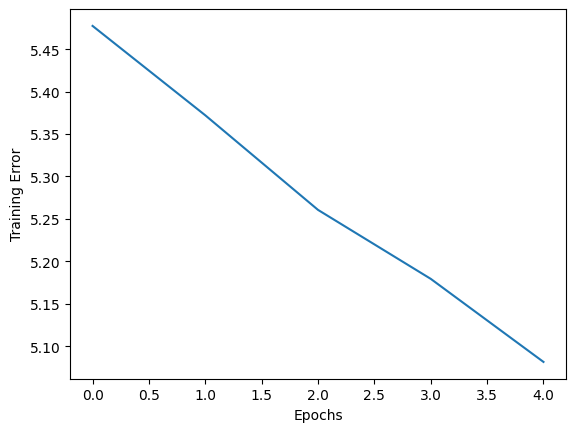

In [43]:
from keras.models import load_model

if os.path.exists('regression_model1'):
    model1 = load_model('regression_model1')
else:
    history = model1.fit([train['new_user_id'], train['new_book_id']], train['Book-Rating'], epochs=5, verbose=1)
    model1.save('regression_model1')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [45]:
model1.evaluate([test['new_user_id'], test['new_book_id']], test['Book-Rating'])

1695/1695 [==============================] - 2s 966us/step - loss: 12.9824


12.982351303100586

In [47]:
predictions = model1.predict([test['new_user_id'].head(20), test['new_book_id'].head(20)])

[print(predictions[i], test['Book-Rating'].iloc[i]) for i in range(0,20)]

1/1 [==============================] - 0s 23ms/step
[0.50469756] 5
[0.07561013] 0
[0.9647428] 0
[3.0564287] 8
[6.2991343] 10
[1.8788239] 0
[2.8019812] 0
[0.9940767] 0
[0.00011989] 0
[11.979039] 0
[0.8862016] 0
[-0.0729318] 0
[4.4332395] 0
[-0.16159561] 0
[1.7601624] 10
[0.30744812] 0
[2.9661367] 0
[9.492433] 10
[1.5733092] 0
[3.1353383] 0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Modelo 2

In [57]:
from libreco.data import random_split, DatasetPure
from libreco.algorithms import NCF  # pure data, 
from libreco.evaluation import evaluate

In [61]:
data = ratings
data.columns = ["user", "item", "label"]

In [62]:
train_data, eval_data, test_data = random_split(ratings, multi_ratios=[0.8, 0.1, 0.1])

In [63]:
train_data, data_info= DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

In [ ]:
ncf = NCF(
    task="rating",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=16,
    n_epochs=20,
    lr=1e-3,
    batch_size=500,
    num_neg=1,
) #rating es para explicit feedback

In [66]:
# monitor metrics on eval data during training
ncf.fit(
    train_data,
    neg_sampling=False, #for rating, this param is false else True
    verbose=2,
    eval_data=eval_data,
    metrics=["loss"],
)

# do final evaluation on test data
evaluate(
    model=ncf,
    data=test_data,
    neg_sampling=False,
    metrics=["loss"],
)

Training start time: 2023-11-08 19:10:58


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:28<00:00, 22.37it/s]


Epoch 1 elapsed: 328.921s
	 train_loss: 6.5614


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 75.99it/s]


	 eval rmse: 3.6347


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:38<00:00, 21.76it/s]


Epoch 2 elapsed: 338.181s
	 train_loss: 5.1628


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 100.19it/s]


	 eval rmse: 3.6951


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [25:14<00:00,  4.86it/s]


Epoch 3 elapsed: 1514.366s
	 train_loss: 4.299


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 79.56it/s]


	 eval rmse: 3.7490


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:52<00:00, 20.86it/s]


Epoch 4 elapsed: 352.759s
	 train_loss: 3.5739


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 86.74it/s]


	 eval rmse: 3.8675


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:58<00:00, 20.52it/s]


Epoch 5 elapsed: 358.641s
	 train_loss: 3.0781


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 88.88it/s]


	 eval rmse: 3.8747


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:33<00:00, 22.06it/s]


Epoch 6 elapsed: 333.634s
	 train_loss: 2.7357


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 84.02it/s]


	 eval rmse: 3.9709


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:24<00:00, 22.68it/s]


Epoch 7 elapsed: 324.473s
	 train_loss: 2.5019


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 88.23it/s]


	 eval rmse: 4.0016


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:29<00:00, 22.31it/s]


Epoch 8 elapsed: 329.819s
	 train_loss: 2.3314


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 88.51it/s]


	 eval rmse: 4.0225


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:18<00:00, 23.13it/s]


Epoch 9 elapsed: 318.114s
	 train_loss: 2.1923


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 84.11it/s]


	 eval rmse: 4.1005


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:20<00:00, 22.95it/s]


Epoch 10 elapsed: 320.713s
	 train_loss: 2.0726


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 80.22it/s]


	 eval rmse: 4.1073


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:13<00:00, 23.45it/s]


Epoch 11 elapsed: 313.817s
	 train_loss: 1.9761


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 93.57it/s]


	 eval rmse: 4.0845


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:21<00:00, 22.92it/s]


Epoch 12 elapsed: 321.108s
	 train_loss: 1.8975


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 89.32it/s]


	 eval rmse: 4.1109


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:23<00:00, 22.78it/s]


Epoch 13 elapsed: 323.102s
	 train_loss: 1.8122


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 77.53it/s]


	 eval rmse: 4.1684


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:21<00:00, 22.91it/s]


Epoch 14 elapsed: 321.246s
	 train_loss: 1.7605


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 92.49it/s]


	 eval rmse: 4.0691


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:18<00:00, 23.07it/s]


Epoch 15 elapsed: 318.974s
	 train_loss: 1.7058


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 96.56it/s]


	 eval rmse: 4.1140


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:17<00:00, 23.16it/s]


Epoch 16 elapsed: 317.706s
	 train_loss: 1.6509


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 103.21it/s]


	 eval rmse: 4.1047


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:17<00:00, 23.20it/s]


Epoch 17 elapsed: 317.217s
	 train_loss: 1.6133


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 89.27it/s]


	 eval rmse: 4.1319


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:29<00:00, 22.32it/s]


Epoch 18 elapsed: 329.742s
	 train_loss: 1.575


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 78.01it/s]


	 eval rmse: 4.1613


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:45<00:00, 21.32it/s]


Epoch 19 elapsed: 345.177s
	 train_loss: 1.529


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 87.69it/s]


	 eval rmse: 4.1778


train: 100%|███████████████████████████████████████████████████████████████████████| 7359/7359 [05:35<00:00, 21.91it/s]


Epoch 20 elapsed: 335.852s
	 train_loss: 1.4988


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 86.78it/s]


	 eval rmse: 4.1671


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 76.55it/s]


{'loss': 4.1585937}

In [77]:
def buscar_libros_por_ISBN(diccionario):
    resultados = []

    for user_id, valores in diccionario.items():
        for valor in valores:
            libros_encontrados = books[books['ISBN'] == valor]
            if not libros_encontrados.empty:
                for idx, row in libros_encontrados.iterrows():
                    resultados.append([row['ISBN'], row['Book-Title'], row['Book-Author']])
    
    if resultados:
        tabla_resultados = pd.DataFrame(resultados, columns=['ISBN', 'Book-Title', 'Book-Author'])
        return tabla_resultados
    else:
        return None

In [72]:
# predecir preferencia del usario 276747 en ISBN 0060517794
ncf.predict(user=276747, item='0943066433')

array([7.1623745], dtype=float32)

In [78]:
# recommendar 10 ISBN para usuario 276747
buscar_libros_por_ISBN(ncf.recommend_user(user=276747, n_rec=10))

,ISBN,Book-Title,Book-Author
0,0740723367,The Meaning Of Life,Bradley Trevor Greive
1,0743444477,Letters for Emily,Camron Wright
2,0152802177,Stellaluna,Janell Cannon
3,0505522764,Dreams of an Eagle (Paranormal Romance),Lori Handeland
4,0446677736,The Score (Parker Novels),Richard Stark
5,044990928X,Operating Instructions: A Journal of My Son's ...,Anne Lamott
6,0064404773,Beauty: A Retelling of the Story of Beauty and...,Robin McKinley
7,0671787268,The Girls He Adored,Jonathan Nasaw
